20171006
/Users/caoy0a/Documents/SCRATCH/LosAngelesT71F479D/pyrite/ERA5/raw/ERA-5_N32_N36_W120_W115_20171006_14.grb
[-120.   -119.75 -119.5  -119.25 -119.   -118.75 -118.5  -118.25 -118.
 -117.75 -117.5  -117.25 -117.   -116.75 -116.5  -116.25 -116.   -115.75
 -115.5  -115.25 -115.   -120.   -119.75 -119.5  -119.25 -119.   -118.75
 -118.5  -118.25 -118.   -117.75 -117.5  -117.25 -117.   -116.75 -116.5
 -116.25 -116.   -115.75 -115.5  -115.25 -115.   -120.   -119.75 -119.5
 -119.25 -119.   -118.75 -118.5  -118.25 -118.   -117.75 -117.5  -117.25
 -117.   -116.75 -116.5  -116.25 -116.   -115.75 -115.5  -115.25 -115.
 -120.   -119.75 -119.5  -119.25 -119.   -118.75 -118.5  -118.25 -118.
 -117.75 -117.5  -117.25 -117.   -116.75 -116.5  -116.25 -116.   -115.75
 -115.5  -115.25 -115.   -120.   -119.75 -119.5  -119.25 -119.   -118.75
 -118.5  -118.25 -118.   -117.75 -117.5  -117.25 -117.   -116.75 -116.5
 -116.25 -116.   -115.75 -115.5  -115.25 -115.   -120.   -119.75 -119.5
 -119.25 -119.   -

[ -39.89632107  -23.88595318   -7.87558528    8.13478261   24.1451505
   40.15551839   56.16588629   72.17625418   88.18662207  104.19698997
  120.20735786  136.21772575  152.22809365  168.23846154  184.24882943
  200.25919732  216.26956522  232.27993311  248.290301    264.3006689
  280.31103679  296.32140468  312.33177258  328.34214047  344.35250836
  360.36287625  376.37324415  392.38361204  408.39397993  424.40434783
  440.41471572  456.42508361  472.43545151  488.4458194   504.45618729
  520.46655518  536.47692308  552.48729097  568.49765886  584.50802676
  600.51839465  616.52876254  632.53913043  648.54949833  664.55986622
  680.57023411  696.58060201  712.5909699   728.60133779  744.61170569
  760.62207358  776.63244147  792.64280936  808.65317726  824.66354515
  840.67391304  856.68428094  872.69464883  888.70501672  904.71538462
  920.72575251  936.7361204   952.74648829  968.75685619  984.76722408
 1000.77759197 1016.78795987 1032.79832776 1048.80869565 1064.81906355
 1080.82

[==================================================] 80/80 slices    1s /     0s 
[2.34245396 2.33804672 2.33363914 2.32923186 2.32482553 2.32042081
 2.31601834 2.31161878 2.30722277 2.30283097 2.29844403 2.2940626
 2.28968732 2.28531885 2.28095784 2.27660494 2.2722608  2.26792608
 2.26360141 2.25928745 2.25498486 2.2506941  2.246415   2.24214719
 2.23789031 2.233644   2.22940789 2.22518162 2.22096484 2.21675717
 2.21255827 2.20836776 2.20418529 2.20001049 2.195843   2.19168245
 2.18752848 2.18338073 2.17923884 2.17510243 2.17097116 2.16684471
 2.16272312 2.15860645 2.15449479 2.15038822 2.14628682 2.14219067
 2.13809985 2.13401445 2.12993455 2.12586021 2.12179148 2.11772839
 2.11367095 2.10961921 2.10557318 2.10153289 2.09749838 2.09346967
 2.08944678 2.08542976 2.08141863 2.07741346 2.07341428 2.06942114
 2.06543409 2.06145317 2.05747843 2.05350991 2.04954767 2.04559175
 2.04164221 2.03769911 2.0337625  2.02983246 2.02590903 2.02199229
 2.01808229 2.01417909 2.01028275 2.00639334 2.0

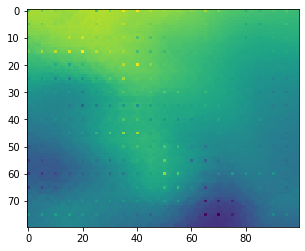

In [75]:
import os
import sys
import numpy as np
import argparse
from pyrite import _utils as ut
import glob
import matplotlib.pyplot as plt
from gigpy import elevation_models

import scipy.interpolate as si
import scipy.interpolate as intp

from scipy.optimize import leastsq
from scipy.stats.stats import pearsonr

from pykrige import OrdinaryKriging

from mintpy.utils import ptime
import scipy.interpolate as intp
import scipy.integrate as intg
import scipy.spatial as ss

import matlab.engine
#### define dicts for model/residual/initial values ###############
def make3dintp(Delfn,lonlist,latlist,hgt,hgtscale):
    '''Returns a 3D interpolation function that can be used to interpolate using llh coordinates.

    Args:
        * Delfn    (np.array) : Array of delay values.
        * lonlist  (np.array) : Array of station longitudes.
        * latlist  (np.array) : Array of station latitudes.
        * hgt      (np.array) : Array of height levels.
        * hgtscale (np.float) : Height scale factor for interpolator.

    Returns:
        * fnc  (function) : 3D interpolation function.

    .. note::
        We currently use the LinearNDInterpolator from scipy.
        '''
    ##Delfn   = Ddry + Dwet. Delay function.
    ##lonlist = list of lons for stations. / x
    ##latlist = list of lats for stations. / y
    nstn = Delfn.shape[0]
    nhgt = Delfn.shape[1]
    xyz = np.zeros((nstn*nhgt,3))
    Delfn = np.reshape(Delfn,(nstn*nhgt,1))
    print('3D interpolation')
    count = 0
    for m in range(nstn):
        for n in range(nhgt):
            xyz[count,0] = lonlist[m]
            xyz[count,1] = latlist[m]
            xyz[count,2] = hgt[n]/hgtscale     #For same grid spacing as lat/lon
            count += 1

    #xyz[:,2] = xyz[:,2] #+ 1e-30*np.random.rand((nstn*nhgt))/hgtscale #For unique Delaunay    
    del latlist
    del lonlist
    del hgt
    if verbose:
        print('PROGRESS: BUILDING INTERPOLATION FUNCTION')
    fnc = intp.LinearNDInterpolator(xyz,Delfn)

    return fnc

def remove_ramp(lat,lon,data):
    # mod = a*x + b*y + c*x*y
    lat = lat/180*np.pi
    lon = lon/180*np.pi  
    lon = lon*np.cos(lat) # to get isometrics coordinates
    
    p0 = [0.0001,0.0001,0.0001,0.0000001]
    plsq = leastsq(residual_trend,p0,args = (lat,lon,data))
    para = plsq[0]
    data_trend = data - func_trend(lat,lon,para)
    corr, _ = pearsonr(data, func_trend(lat,lon,para))
    return data_trend, para, corr

def func_trend(lat,lon,p):
    a0,b0,c0,d0 = p
    
    return a0 + b0*lat + c0*lon +d0*lat*lon


def func_trend_model(lat,lon,p):
    lat = lat/180*np.pi
    lon = lon/180*np.pi  
    lon = lon*np.cos(lat) # to get isometrics coordinates
    a0,b0,c0,d0 = p
    
    return a0 + b0*lat + c0*lon +d0*lat*lon

def residual_trend(p,lat,lon,y0):
    a0,b0,c0,d0 = p 
    return y0 - func_trend(lat,lon,p)



model_dict = {'linear': elevation_models.linear_elevation_model,
                      'onn': elevation_models.onn_elevation_model,
                      'onn_linear': elevation_models.onn_linear_elevation_model,
                      'exp': elevation_models.exp_elevation_model,
                      'exp_linear': elevation_models.exp_linear_elevation_model}

residual_dict = {'linear': elevation_models.residuals_linear,
                      'onn': elevation_models.residuals_onn,
                      'onn_linear': elevation_models.residuals_onn_linear,
                      'exp': elevation_models.residuals_exp,
                      'exp_linear': elevation_models.residuals_exp_linear}

initial_dict = {'linear': elevation_models.initial_linear,
                      'onn': elevation_models.initial_onn,
                      'onn_linear': elevation_models.initial_onn_linear,
                      'exp': elevation_models.initial_exp,
                      'exp_linear': elevation_models.initial_exp_linear}

para_numb_dict = {'linear': 2,
                  'onn' : 3,
                  'onn_linear':4,
                  'exp':2,
                  'exp_linear':3}

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }

k0 = 10
cdic = ut.initconst()
raw_dir = '/Users/caoy0a/Documents/SCRATCH/LosAngelesT71F479D/pyrite/ERA5/raw'
era5_file = '/Users/caoy0a/Documents/SCRATCH/LosAngelesT71F479D/era5_sample.h5'
date_list = ut.read_hdf5(era5_file,datasetName = 'date')[0]
date_list = date_list.astype('U13')
date0 = date_list[k0]
print(date0)
fname0 = glob.glob(raw_dir + '/ERA*' + date0 + '*')[0]
print(fname0)
lvls,latlist,lonlist,gph,tmp,vpr = ut.get_ecmwf('ERA5',fname0,cdic, humidity='Q')
lonlist = lonlist - 360.0
lon = lonlist.flatten() 
lat = latlist.flatten() 

print(lon)
print(lat)
lonStep = lonlist[0,1] - lonlist[0,0]
latStep = latlist[1,0] - latlist[0,0]

maxlon = max(lonlist[0,:])
minlon = min(lonlist[0,:])

maxlat = max(latlist[:,0])
minlat = min(latlist[:,0])

print(lonStep)
print(latStep)

Rescale = 5
lonStep1 = lonStep/Rescale
latStep1 = latStep/Rescale

lonv = np.arange(minlon,maxlon,lonStep1)
latv = np.arange(maxlat,minlat,latStep1)

print(lonv)
print(latv)

lonvv,latvv = np.meshgrid(lonv,latv)


# Make a height scale
hgt = np.linspace(cdic['minAltP'], gph.max().round(), cdic['nhgt'])
# Interpolate pressure, temperature and Humidity of hgt
[Pi,Ti,Vi] = ut.intP2H(lvls, hgt, gph, tmp, vpr, cdic)
# Calculate the delays
[DDry,DWet] = ut.PTV2del(Pi,Ti,Vi,hgt,cdic)

hgt0 = hgt.copy()
idx0 = np.where(((-200<hgt0) & (hgt0 < 3500)))
hgt00 = hgt0[idx0]

hgt0 = list(hgt0)
tzd = dt0[:,:,hgt0.index(hgt00[0])]

print(tzd)
dd0 = DDry.copy()
dw0 = DWet.copy()
dt0 = dd0 + dw0

print(dt0[:,:,1])

dd00 = dd0[:,:,idx0]
dw00 = dw0[:,:,idx0] 
dd00 = dd00.flatten()
dw00 = dw00.flatten()
dt00 = dd00 + dw00

print(len(hgt00))
nk = len(hgt00)

mdd = np.zeros((nk,),dtype = np.float32)
mdw = np.zeros((nk,),dtype = np.float32)
mdt = np.zeros((nk,),dtype = np.float32)

for i in range(nk):
    mdd[i] = np.mean(dd0[:,:,hgt0.index(hgt00[i])])
    mdw[i] = np.mean(dw0[:,:,hgt0.index(hgt00[i])])
    mdt[i] = np.mean(dt0[:,:,hgt0.index(hgt00[i])])


R = 6371    
BIN_NUMB = 55
max_length = 250
range0 = max_length/2
model = 'spherical'
eng = matlab.engine.start_matlab()
row,col = lonvv.shape
Delf_dense = np.zeros((nk,row,col),dtype = np.float32)

hx = hgt00.copy()
rescale_h = 10
hx_step = hx[1] - hx[0]
hx_step2 = hx_step/rescale_h
hgt_dense = np.arange(min(hx),max(hx),hx_step2)
print(hgt_dense)

## interp horizontal 
prog_bar = ptime.progressBar(maxValue=nk)
for i in range(nk):
#for i in range(1):
    k0 = i
    tzd = dt0[:,:,hgt0.index(hgt00[k0])]
    tzd = tzd.flatten()
    tzd0, para, corr= remove_ramp(lat,lon,tzd)
    trend = func_trend_model(latvv,lonvv,para)
    #trend = trend.reshape(row,col)
    uk = OrdinaryKriging(lon, lat, tzd0, coordinates_type = 'geographic', nlags=BIN_NUMB)
    Semivariance_trend = 2*(uk.semivariance)    
    x0 = (uk.lags)/180*np.pi*R
    y0 = Semivariance_trend

    LL0 = x0[x0< max_length]
    SS0 = y0[x0< max_length]
    sill0 = max(SS0)
    sill0 = sill0.tolist()

    LLm = matlab.double(LL0.tolist())
    SSm = matlab.double(SS0.tolist()) 
    tt = eng.variogramfit(LLm,SSm,range0,sill0,[],'nugget',0.00001,'model',model)
    variogram_para0 = tt[0]

    para = variogram_para0[0:3]
    para[1] = para[1]/6371/np.pi*180
    #print(para)
    uk.variogram_model_parameters = para
    z0,s0 = uk.execute('grid', lonv, latv, n_closest_points = 20,backend='loop')
    #ax.plot(x0,y0,'r.')
    Delf_dense[i,:,:] = z0 + trend
    prog_bar.update(i+1, every=1, suffix='{}/{} slices'.format(i+1, nk))
prog_bar.close()

print(tzd0)
print(trend)
## interp latitude
nk2 = len(hgt_dense)
Delf_dense2 = np.zeros((nk2,row,col),dtype = np.float32)


prog_bar = ptime.progressBar(maxValue=row)
for i in range(row):
    for j in range(col):
        hy = Delf_dense[:,i,j]
        #print(hy)
        tck = intp.interp1d(hx,hy,kind='cubic')
        temp = tck(hgt_dense)
        Delf_dense2[:,i,j] = temp
    prog_bar.update(i+1, every=5, suffix='{}/{} slices'.format(i+1, row))
prog_bar.close()
print(temp)

#fnc = make3dintp(Delf_dense2,lonvv,latvv,hgt_dense,1)

linearint = si.RegularGridInterpolator((hgt_dense,latv[::-1], lonv), Delf_dense2[:,::-1,:], method='linear', bounds_error=False, fill_value = 0.0)
    
print('Finish')
eng.quit()

## interp InSAR

geo_file = '/Users/caoy0a/Documents/SCRATCH/LosAngelesT71F479D/geometryRadar.h5'
lats = ut.read_hdf5(geo_file,datasetName='latitude')[0]
lons = ut.read_hdf5(geo_file,datasetName='longitude')[0]
heis = ut.read_hdf5(geo_file,datasetName='height')[0]

val = linearint(np.vstack((heis.flatten(),lats.flatten(), lons.flatten())).T)
print('finish')
row0,col0 = lats.shape
print(val.shape)
val = val.reshape(row0,col0)
#####

datasetDict = dict()
datasetDict['delay'] = val
meta = ut.read_attr(geo_file)
ut.write_h5(datasetDict, '/Users/caoy0a/Documents/SCRATCH/LosAngelesT71F479D/delay_test.h5', metadata=meta, ref_file=None, compression=None)

dd = Delf_dense2[1,:,:]
dd = dd.reshape(row,col)
print(dd)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(dd)
plt.show()
    